In [1]:
#Importing the required packages
#Ignoring warnings
import warnings
warnings.filterwarnings('ignore') 
import numpy as np
import pandas as pd
from time import time
import operator
import string
import re
import os

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

import sklearn
from sklearn import utils
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import f1_score

import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

import tqdm
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

import tensorflow as tf
import keras.preprocessing
import keras.layers
import keras.models
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,Model
from keras.engine.topology import Layer
from keras.layers import Activation,  Wrapper
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Bidirectional, Flatten, SpatialDropout1D, LSTM
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras import initializers, regularizers, constraints
from keras.callbacks import (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard)

Using TensorFlow backend.


In [2]:
#Set current working directory to the path of files saved
os.chdir('D:/Project')

In [3]:
# Loading the original train data into dataframe
train_df_original = pd.read_csv("train.csv")

In [4]:
# Storing the word count of original train data into a list
train_original_len = [len(x.split()) for x in train_df_original['question_text'].tolist()]

Text(0, 0.5, 'frequency')

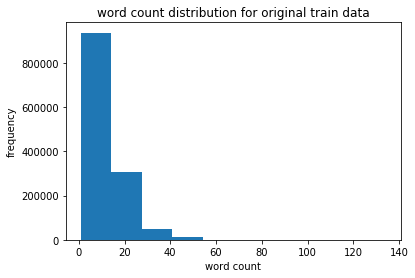

In [5]:
# Plotting histogram to show the word count distribution before text preprocessing
plt.hist(train_original_len)
plt.title('word count distribution for original train data')
plt.xlabel('word count')
plt.ylabel('frequency')

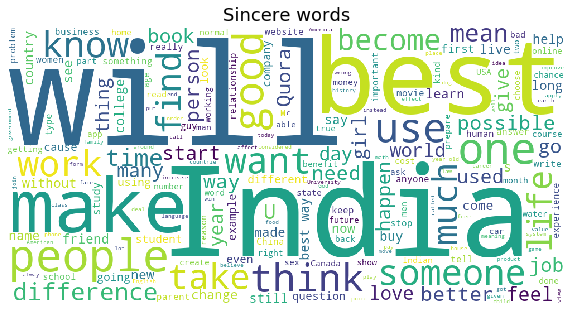

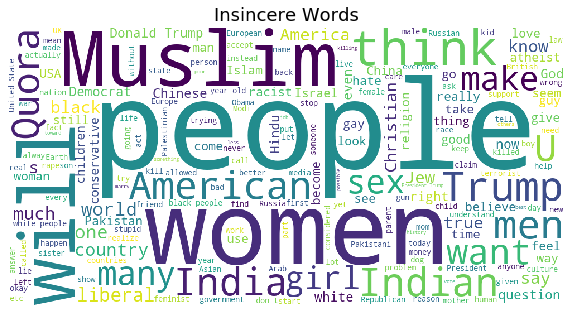

In [6]:
# Word cloud for sincere and insincere words of train data before text preprocessing
def wordcloud_draw(data, title, color='black'):
    words = ' '.join(data)
    wordcloud = WordCloud(
        background_color=color,
        width=1000,
        height=500
    ).generate(words)
    plt.figure(1,figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.title(title, fontdict={'fontsize':18})
    plt.axis('off')
    plt.show()

title = "Sincere words"
wordcloud_draw(train_df_original[train_df_original['target']==0]['question_text'], title, 'white')
title = "Insincere Words"
wordcloud_draw(train_df_original[train_df_original['target']==1]['question_text'], title, 'white')

In [7]:
#Commenting below code, data is pre-processed and cleaned data is attached
'''
#Loading train data into a dataframe and displaying the first 5 rows
train_df = pd.read_csv("train.csv")
print(train_df.head(5))

#Loading test data into a dataframe and displaying the first 5 rows
test_df = pd.read_csv("test.csv")
print(test_df.head(5))

#Importing contractions
from pycontractions import Contractions
cont = Contractions(api_key="glove-twitter-100")
cont.load_models()

#Defining Function for Expanding contractions
def contraction_removal(record):
    global cont
    corrections = list(cont.expand_texts([record["question_text"]], precise=True))
    record["question_text"] = corrections[0]
    return record

#Expanding contractions in train_df
train_df = train_df.progress_apply(contraction_removal, axis=1)
train_df

#Expanding contractions in test_df
test_df = test_df.progress_apply(contraction_removal, axis=1)
test_df


#Defining function to correct misspelled words
from autocorrect import Speller
def spell_check_eng(record):
    check = Speller(lang='en')
    record["question_text"] = check(record["question_text"])
    return record


#Correcting misspelled words in train_df
train_df = train_df.progress_apply(spell_check_eng, axis=1)
train_df

#Correcting misspelled words in test_df
test_df = test_df.progress_apply(spell_check_eng, axis=1)
test_df

#Importing segmenter function from ekphrasis package
from ekphrasis.classes.segmenter import Segmenter
# segmenter using the word statistics from english Wikipedia
seg_eng = Segmenter(corpus="english") 

#Defining word segmentation function
def word_segmentation(record):
    global seg_eng
    record["question_text"] = seg_eng.segment(record["question_text"])
    return record

#Word segmentation of train_df
train_df = train_df.progress_apply(word_segmentation, axis =1)
train_df.head(30)

#Word segmentation of test_df
test_df = test_df.progress_apply(word_segmentation, axis =1)
test_df.head(30)


#Defining function to remove punctuations
def punc_remove_wrapper(record, maxlen=None):
    puncts = [
         ',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&',
        '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
        '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',
        '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '“', '★', '”',
        '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾',
        '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼',
        '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
        'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»',
        '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
        '¹', '≤', '‡', '√', '«', '»', '´', 'º', '¾', '¡', '§', '£', '₤']
    no_punc = record["question_text"]
    for punct in puncts:   
        if punct in record["question_text"]:
            no_punc = no_punc.replace(punct, '')
            #print(no_punc)
    return no_punc


#Removing punctuations from train_df 
train_df["question_text"] = train_df.progress_apply(punc_remove_wrapper, axis = 1)
print(train_df["question_text"].head(10))

#Removing punctuations from test_df 
test_df["question_text"] = test_df.progress_apply(punc_remove_wrapper, axis = 1)
print(test_df["question_text"].head(10))

#Storing english stop words into stop_words
stop_words = set(stopwords.words('english'))
stop_words

#Removing stop words from train_df
train_df["question_text"] = train_df["question_text"].progress_apply(lambda x: " ".join([w for w in str(x).lower().split() if w not in stop_words]))
print(train_df["question_text"].head(10))

#Removing stop words from test_df
test_df["question_text"] = test_df["question_text"].progress_apply(lambda x: " ".join([w for w in str(x).lower().split() if w not in stop_words]))
print(test_df["question_text"].head(10))

#Removing numbers from train_df
train_df["question_text"] = train_df["question_text"].progress_apply(lambda x: re.sub("\d+","",x))
print(train_df["question_text"].head(10))

#Removing numbers from test_df
test_df["question_text"] = test_df["question_text"].progress_apply(lambda x: re.sub("\d+","",x))
print(test_df["question_text"].head(10))

#Loading the dataframe into a new CSV file
train_df.to_csv ('preprocessed_train_df.csv', index = False, header=True)

#Loading the dataframe into a new CSV file
test_df.to_csv ('preprocessed_test_df.csv', index = False, header=True)

'''

'\n#Loading train data into a dataframe and displaying the first 5 rows\ntrain_df = pd.read_csv("train.csv")\nprint(train_df.head(5))\n\n#Loading test data into a dataframe and displaying the first 5 rows\ntest_df = pd.read_csv("test.csv")\nprint(test_df.head(5))\n\n#Importing contractions\nfrom pycontractions import Contractions\ncont = Contractions(api_key="glove-twitter-100")\ncont.load_models()\n\n#Defining Function for Expanding contractions\ndef contraction_removal(record):\n    global cont\n    corrections = list(cont.expand_texts([record["question_text"]], precise=True))\n    record["question_text"] = corrections[0]\n    return record\n\n#Expanding contractions in train_df\ntrain_df = train_df.progress_apply(contraction_removal, axis=1)\ntrain_df\n\n#Expanding contractions in test_df\ntest_df = test_df.progress_apply(contraction_removal, axis=1)\ntest_df\n\n\n#Defining function to correct misspelled words\nfrom autocorrect import Speller\ndef spell_check_eng(record):\n    check

In [7]:
# Loading the preprocessed train data into dataframe
train_df = pd.read_csv('preprocessed_train_df.csv')

In [8]:
# Dropping the null values in the data
train_df = train_df.dropna()

In [9]:
# Storing the word count of train data into a list
train_len = [len(x.split()) for x in train_df['question_text'].tolist()]

Text(0, 0.5, 'frequency')

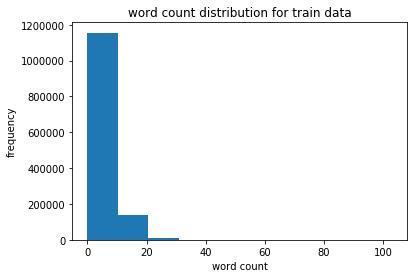

In [10]:
# Plotting histogram to show the word count distribution after text preprocessing
plt.hist(train_len)
plt.title('word count distribution for train data')
plt.xlabel('word count')
plt.ylabel('frequency')

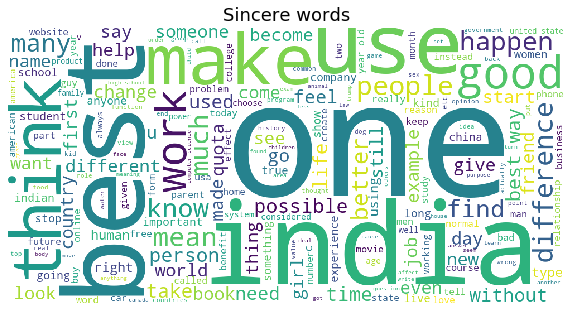

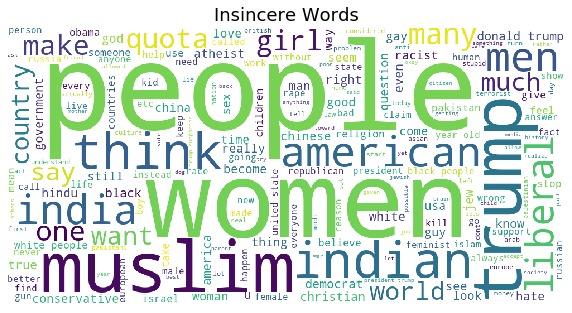

In [11]:
# Word cloud for sincere and insincere words of train data after text preprocessing
def wordcloud_draw(data, title, color='black'):
    words = ' '.join(data)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=1000,
                      height=500
                     ).generate(words)
    plt.figure(1,figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.title(title, fontdict={'fontsize':18})
    plt.axis('off')
    plt.show()
    
title = "Sincere words"
wordcloud_draw(train_df[train_df['target']==0]['question_text'], title, 'white')
title = "Insincere Words"
wordcloud_draw(train_df[train_df['target']==1]['question_text'], title, 'white')

In [12]:
# Filtering target values into a new dataframe for splitting the data using target class values
target_df = train_df.pop('target').to_frame()

In [13]:
# Splitting the train data into train and test data using stratified sampling
train_data, test_data, train_target, test_target = train_test_split(train_df, target_df, stratify=target_df, test_size=0.25, random_state=38)

In [14]:
# Displaying the target class values before and after the data splitting
from collections import Counter
print(f'Original train dataset shape: {Counter(target_df.target)}')
print(f'Resampled train dataset shape: {Counter(train_target.target)}')
print(f'Resampled test dataset shape: {Counter(test_target.target)}')

Original train dataset shape: Counter({0: 1225076, 1: 80795})
Resampled train dataset shape: Counter({0: 918807, 1: 60596})
Resampled test dataset shape: Counter({0: 306269, 1: 20199})


In [15]:
# Combining the train_data and train_target dataframes into train_df1 dataframe
train_df1 = train_data.join(train_target)

In [16]:
# Combining the test_data and test_target dataframes into test_df dataframe
test_df = test_data.join(test_target)

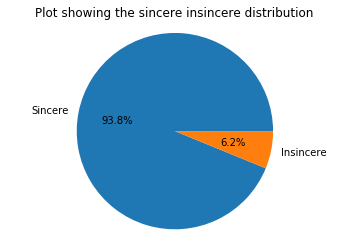

In [17]:
#Piechart showing the share of sincere and insincere records of train dataset:
values = [len(train_df1[train_df1['target']==0]),len(train_df1[train_df1['target']==1])]
labels = ["Sincere","Insincere"]
plt.pie(values,labels=labels,autopct='%1.1f%%')
plt.title('Plot showing the sincere insincere distribution')
plt.axis('equal')
plt.show()

In [18]:
# Filtering the question text data 
words_train = train_df1['question_text']
words_test = test_df['question_text']

In [19]:
# Converting the series dataframe to string
words_train = words_train.to_string()
words_test = words_test.to_string()

In [20]:
# Removing the \n and digits from the question text
words_train = ''.join([i for i in words_train if not i.isdigit()])
words_train = words_train.replace('\n', '')

In [21]:
# Removing the \n and digits from the question text
words_test = ''.join([i for i in words_test if not i.isdigit()])
words_test = words_test.replace('\n', '')

In [22]:
# Finding the number of unique words in the train data
len(set(words_train.split()))

118171

In [23]:
# Finding the number of unique words in the test data
len(set(words_test.split()))

70820

In [24]:
# Finding the max no of words in the question text in train and test data
print('Max word length of questions in train is {0:.0f}.'.format(np.max(train_df1['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in test is {0:.0f}.'.format(np.max(test_df['question_text'].apply(lambda x: len(x.split())))))

Max word length of questions in train is 103.
Max word length of questions in test is 33.


In [25]:
# Hyper parameters for performing tokenization
max_features = 188991 #total number of unique words = unique words in both train and test datasets
max_len = 100 # max number of words in a question to use as the max word length is around 100 for train dataset.

In [26]:
## fill up the missing values
train_X = train_df1["question_text"].fillna("_na_").values
test_X = test_df["question_text"].fillna("_na_").values

In [27]:
#Tokenize our training data
tk = Tokenizer(lower = True, filters='', num_words=max_features, oov_token = True)
tk.fit_on_texts(list(train_X))

In [28]:
# Get our training data word index
word_index = tk.word_index

In [29]:
#Encode training and test data sentences into sequences
train_X = tk.texts_to_sequences(train_X)
test_X = tk.texts_to_sequences(test_X)

In [30]:
# Pad the train sequece and Displaying the padded train sequence
train_X = pad_sequences(train_X, maxlen = max_len, padding='pre', truncating='post')
train_X

array([[    0,     0,     0, ...,   413,   105,    84],
       [    0,     0,     0, ...,   334,   462,  2427],
       [    0,     0,     0, ...,   268,    10,   327],
       ...,
       [    0,     0,     0, ...,  3679,   168,  1227],
       [    0,     0,     0, ...,  9140,  2896, 15536],
       [    0,     0,     0, ...,    24,   604,   543]])

In [31]:
# Pad the test sequence and Displaying the padded test sequence
test_X = pad_sequences(test_X, maxlen = max_len, padding='pre', truncating='post')
test_X

array([[   0,    0,    0, ...,  893,  714, 1434],
       [   0,    0,    0, ...,   52,  387,   93],
       [   0,    0,    0, ..., 1245, 4525, 8816],
       ...,
       [   0,    0,    0, ...,  521,  821,  953],
       [   0,    0,    0, ...,  210,   70, 3036],
       [   0,    0,    0, ...,  934, 2871, 2486]])

In [32]:
## Get the target values
train_y = train_df1['target'].values
test_y = test_df['target'].values

In [33]:
# Fuction for loading word embedding and returns a dictionary of embedding indexes 
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='utf8'))
        
    return embeddings_index

In [34]:
# Assigning the file path for glove word embedding
glove = 'glove.840B.300d.txt'

In [35]:
# Loading glove word embedding 
print("Extracting GloVe embedding ...")
embed_glove = load_embed(glove)

Extracting GloVe embedding ...


In [36]:
# Removing the special character fron train dataset
train_df1["question_text"] = train_df1["question_text"].str.replace('₹','')
# Removing the special character fron train dataset
test_df["question_text"] = test_df["question_text"].str.replace('₹','')

In [37]:
# Function for building vocabulary using train dataset and returns dictionary of words with corresponding indexes based on frquencies 
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab


In [38]:
# Calling build vocab function
vocab = build_vocab(train_df1['question_text'])

In [39]:
# Function for calculating the coverage of embeddings for vacbulary and returns unkown words
def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

In [40]:
# Unknown words are stored in oov_glove 
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)

Glove : 
Found embeddings for 60.03% of vocab
Found embeddings for  99.08% of all text


In [41]:
# Function for creating embedding weights and returns an array with embedding weights
def create_embedding_weights(embeddings_index, word_index, max_features):
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    #embed_size = np.stack(embed_glove.values()).shape[1]
    embed_size = all_embs.shape[1]
    word_index = word_index
    embedding_weights = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_weights[i] = embedding_vector
    
    return embedding_weights

In [42]:
# Calling a function for creating embedding weights and stored in glove_weights
glove_weights = create_embedding_weights(embed_glove, word_index, max_features)
glove_weights

array([[ 0.2308306 ,  0.37903609,  0.44972364, ..., -0.10759271,
         0.8033005 ,  0.76934616],
       [-0.049291  ,  0.20483001, -0.12808   , ..., -0.28529   ,
         0.33702999,  0.12335   ],
       [-0.26879001,  0.17483   , -0.35633001, ..., -0.17138   ,
         0.26846001,  0.19866   ],
       ...,
       [ 0.70505202, -1.03275962, -0.48476717, ..., -0.21882789,
        -0.19909495, -0.55734744],
       [ 0.34078353,  0.59273886,  0.52793612, ..., -0.95647201,
         1.02573708,  0.26598411],
       [-0.14108687, -0.43264467,  0.27092758, ...,  0.22048483,
         0.40483437,  0.08006864]])

In [43]:
# defining the embed size
embed_size = 300

# Path of the best weights model
MODEL_PATH = "weights_best15.hdf5"

In [44]:
# defining squash function
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True)
    scale = K.sqrt(s_squared_norm + K.epsilon())
    return x / scale

In [45]:
# keras capule layer for deep neural networks
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, kernel_size=(9, 1), share_weights=True,
                 activation='default', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_size = kernel_size
        self.share_weights = share_weights
        if activation == 'default':
            self.activation = squash
        else:
            self.activation = Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     # shape=self.kernel_size,
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule,
                                            self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        # final u_hat_vecs.shape = [None, num_capsule, input_num_capsule, dim_capsule]

        b = K.zeros_like(u_hat_vecs[:, :, :, 0])  # shape = [None, num_capsule, input_num_capsule]
        for i in range(self.routings):
            b = K.permute_dimensions(b, (0, 2, 1))  # shape = [None, input_num_capsule, num_capsule]
            c = K.softmax(b)
            c = K.permute_dimensions(c, (0, 2, 1))
            b = K.permute_dimensions(b, (0, 2, 1))
            outputs = self.activation(tf.keras.backend.batch_dot(c, u_hat_vecs, [2, 2]))
            if i < self.routings - 1:
                b = tf.keras.backend.batch_dot(outputs, u_hat_vecs, [2, 3])

        return outputs

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [46]:
# Keras Wrapper that implements a DropConnect Layer.
class DropConnect(Wrapper):
    def __init__(self, layer, prob=1., **kwargs):
        self.prob = prob
        self.layer = layer
        super(DropConnect, self).__init__(layer, **kwargs)
        if 0. < self.prob < 1.:
            self.uses_learning_phase = True

    def build(self, input_shape):
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True
        super(DropConnect, self).build()

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def call(self, x):
        if 0. < self.prob < 1.:
            self.layer.kernel = K.in_train_phase(K.dropout(self.layer.kernel, self.prob), self.layer.kernel)
            self.layer.bias = K.in_train_phase(K.dropout(self.layer.bias, self.prob), self.layer.bias)
        return self.layer.call(x)

In [47]:
# defining get_model function
def get_model(glove_weights):
    # Input for variable-length sequences of integers
    input_layer = Input(shape=(max_len,))

    # embedding layer
    x = Embedding(max_features, embed_size, weights=[glove_weights], trainable=False)(input_layer)

    # dropout
    x = SpatialDropout1D(rate=0.24)(x)

    # Adding two bidirectional lstm
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    
    # Capsule layer
    capsul = Capsule(num_capsule=10, dim_capsule=10, routings=4, share_weights=True)(x) 
    capsul = Flatten()(capsul)
    capsul = DropConnect(Dense(32, activation="relu"), prob=0.02)(capsul)
    
    # output layer(sigmoid)
    output_layer = Dense(1, activation="sigmoid")(capsul)
    model = Model(inputs=input_layer, outputs=output_layer)

    # compile model
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [48]:
# defining get_callbacks function
def get_callbacks():
    earlystopping = EarlyStopping(monitor='val_loss',
                                  min_delta=0.0001,
                                  patience=2,
                                  verbose=2,
                                  mode='auto')
    checkpoint = ModelCheckpoint(filepath=MODEL_PATH,
                                 monitor='val_loss',
                                 save_best_only=True,
                                 mode='min',
                                 verbose=2)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  min_lr=0.0001,
                                  factor=0.6,
                                  patience=1,
                                  verbose=2)
    tensorboard = TensorBoard(log_dir='logs2/{}'.format(time()))
    
    return [earlystopping, checkpoint, reduce_lr, tensorboard]

In [49]:
best_thres = []
y_test = np.zeros((test_X.shape[0], ))        

# splitting the train data into train and validation data using stratified sampling
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, stratify=train_y, test_size=0.2, random_state=38) 

# calling the get_model function
model = get_model(glove_weights)
print(model.summary())
'''
# get class weight
weights = None
weights = utils.class_weight.compute_class_weight('balanced', np.unique(y_train), y_train) 
        
# training the model
history = model.fit(X_train, y_train, batch_size=512, epochs=5, 
          validation_data=(X_val, y_val), 
          verbose=2, class_weight=weights, callbacks=get_callbacks())

'''

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          56697300  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          439296    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          164352    
_________________________________________________________________
capsule_1 (Capsule)          (None, 10, 10)            12800     
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
__________

"\n# get class weight\nweights = None\nweights = utils.class_weight.compute_class_weight('balanced', np.unique(y_train), y_train) \n        \n# training the model\nhistory = model.fit(X_train, y_train, batch_size=512, epochs=5, \n          validation_data=(X_val, y_val), \n          verbose=2, class_weight=weights, callbacks=get_callbacks())\n\n"

In [50]:
# reload best model
model.load_weights(MODEL_PATH)

# predicting the target class values for validation data using the trained model
pred_y_val = model.predict([X_val], batch_size=1024, verbose=2)

# calculating and displaying the f1 score at respective thresholds
thresholds = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    res = metrics.f1_score(np.squeeze(y_val), (np.squeeze(pred_y_val)>thresh).astype(int))
    thresholds.append([thresh, res])
    print("F1 score at threshold {0} is {1}".format(thresh, res))

# displaying the best threshold    
thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
print("Best threshold: ", best_thresh)

# predicting the target class values for test data using the trained model
y_test = y_test + np.squeeze(model.predict([test_X], batch_size=1024, verbose=2))
    

F1 score at threshold 0.1 is 0.5425620987998884
F1 score at threshold 0.11 is 0.551170464288498
F1 score at threshold 0.12 is 0.558622705172826
F1 score at threshold 0.13 is 0.5653457569273274
F1 score at threshold 0.14 is 0.5719805696621771
F1 score at threshold 0.15 is 0.5781574953628239
F1 score at threshold 0.16 is 0.5833166633326665
F1 score at threshold 0.17 is 0.587542770979528
F1 score at threshold 0.18 is 0.5926187741156372
F1 score at threshold 0.19 is 0.5976495918184265
F1 score at threshold 0.2 is 0.6021401073084969
F1 score at threshold 0.21 is 0.605749423520369
F1 score at threshold 0.22 is 0.6102794411177646
F1 score at threshold 0.23 is 0.6138231946376628
F1 score at threshold 0.24 is 0.6174436475409835
F1 score at threshold 0.25 is 0.6206583427922815
F1 score at threshold 0.26 is 0.6236100633056713
F1 score at threshold 0.27 is 0.6259749742772743
F1 score at threshold 0.28 is 0.6284870254120649
F1 score at threshold 0.29 is 0.631489592883094
F1 score at threshold 0.3 i

In [51]:
# Storing the predicted target values for test dataset into dataframe
y_test = y_test.reshape((-1, 1))
test_df['prediction'] = (y_test>np.mean(best_thresh)).astype(int)

In [52]:
# Confusion matrix for validation data
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, (pred_y_val>np.mean(best_thresh)).astype(int))

array([[177806,   5956],
       [  3505,   8614]], dtype=int64)

In [53]:
# Confusion matrix for test data
confusion_matrix(test_y, (y_test>np.mean(best_thresh)).astype(int))

array([[296127,  10142],
       [  5820,  14379]], dtype=int64)

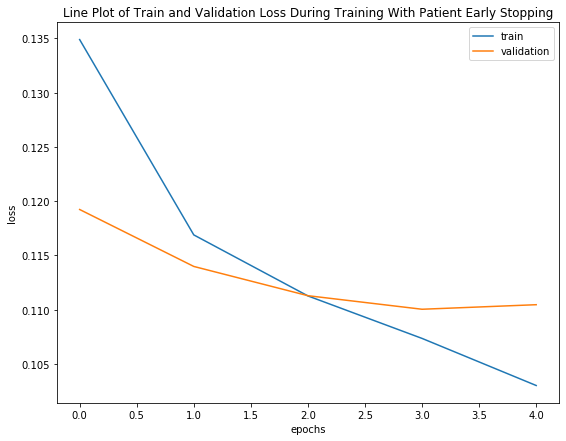

In [54]:
# plot training history of Train and Validation Loss During model Training
from matplotlib import pyplot
pyplot.figure(figsize=(9,7))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.title('Line Plot of Train and Validation Loss During Training With Patient Early Stopping')
pyplot.legend()
pyplot.xlabel('epochs')
pyplot.ylabel('loss')
pyplot.show()

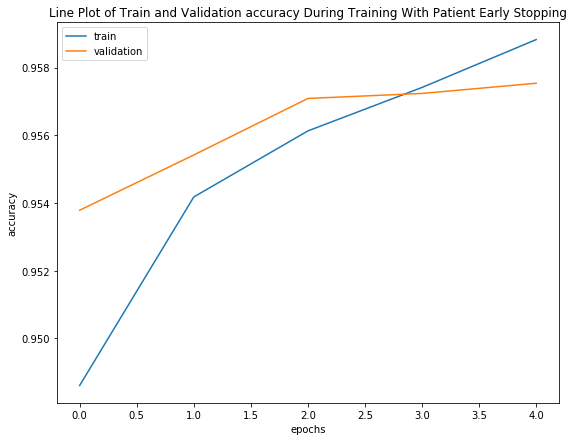

In [55]:
# plot training history of Train and Validation accuracy During model Training
pyplot.figure(figsize=(9,7))
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='validation')
pyplot.title('Line Plot of Train and Validation accuracy During Training With Patient Early Stopping')
pyplot.legend()
pyplot.xlabel('epochs')
pyplot.ylabel('accuracy')
pyplot.show()

In [54]:
test_df[(test_df.target==1)&(test_df.prediction==1)]

,qid,question_text,target,prediction
1150449,e169f41dae60cf0f6ab3,white people pretend like black culture sort g...,1,1
322544,3f3682f04a7c1526e52b,drs memorials removed public view due racism a...,1,1
1277838,fa6f58846a6a64a7b100,difference catholics islamists catholics also ...,1,1
337412,421d08c64dec61fdc5fb,undocumented alien students get full scholarsh...,1,1
143091,1c00d7636481c6c428e1,chinese lick bodies,1,1
...,...,...,...,...
1083683,d45d6652040d2074fc4c,trump supporters keep thinking genetically int...,1,1
1149427,e1366c9e3fbc6331ba19,im black long old plantation racist,1,1
530004,67c5d97d1321fa70ef86,gay dad kiss neck friend extremely mature many...,1,1
116354,16c475ab6815c3fe6cc5,leftist liberals support propaganda similar nazis,1,1


In [55]:
test_df[(test_df.target==1)]

,qid,question_text,target,prediction
1150449,e169f41dae60cf0f6ab3,white people pretend like black culture sort g...,1,1
322544,3f3682f04a7c1526e52b,drs memorials removed public view due racism a...,1,1
1277838,fa6f58846a6a64a7b100,difference catholics islamists catholics also ...,1,1
337412,421d08c64dec61fdc5fb,undocumented alien students get full scholarsh...,1,1
143091,1c00d7636481c6c428e1,chinese lick bodies,1,1
...,...,...,...,...
730251,8efea08b781e6a7c45d5,everyone suddenly hate mother theresa,1,0
530004,67c5d97d1321fa70ef86,gay dad kiss neck friend extremely mature many...,1,1
351755,44f1407ad4bd6ee690ea,could get someone fired,1,0
116354,16c475ab6815c3fe6cc5,leftist liberals support propaganda similar nazis,1,1


In [56]:
test_df[(test_df.prediction==1)]

,qid,question_text,target,prediction
1150449,e169f41dae60cf0f6ab3,white people pretend like black culture sort g...,1,1
322544,3f3682f04a7c1526e52b,drs memorials removed public view due racism a...,1,1
1277838,fa6f58846a6a64a7b100,difference catholics islamists catholics also ...,1,1
1127282,dce968be95179e1b2397,police officers feel innocent citizens allowed...,0,1
251244,312ae0cdb1c3498a75f8,percent african americans defended slaves,0,1
...,...,...,...,...
1149427,e1366c9e3fbc6331ba19,im black long old plantation racist,1,1
530004,67c5d97d1321fa70ef86,gay dad kiss neck friend extremely mature many...,1,1
961431,bc5c4c6440e64bdc1751,kill legal switzerland,0,1
116354,16c475ab6815c3fe6cc5,leftist liberals support propaganda similar nazis,1,1


In [57]:
from sklearn.metrics import classification_report
target_names = ['Sincere', 'Insincere']
print(classification_report(test_y, (y_test>np.mean(best_thresh)).astype(int), target_names=target_names))

              precision    recall  f1-score   support

     Sincere       0.98      0.97      0.97    306269
   Insincere       0.59      0.71      0.64     20199

    accuracy                           0.95    326468
   macro avg       0.78      0.84      0.81    326468
weighted avg       0.96      0.95      0.95    326468

